# 5-FU ALL Samples

In [ ]:
# Set the working directory to the location of DNA_REPi 5-Fluorouracil data files
source('../../functions.R')
setwd('../../DNA_REPi/5-Fluorouracil/Expression_Mutation_CNA')

In [ ]:
#dir.create("Results", showWarnings = FALSE)
#dir.create('Graphs',showWarnings = FALSE)

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Read and process sensitive DNA_REPi 5-Fluorouracil data (expression, mutation, CNA)

# Load the gene expression, mutation, and CNA files for sensitive samples
expr_sensitive_file = read.table('TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples Gene Expression.tsv', header = T)
mut_sensitive_file = read.table('TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples Mutation.tsv', header = T)
cna_sensitive_file = read.table('TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples CNA.tsv', header = T)

# Remove unwanted samples from the data
olmayan = c('TCGA.AG.A01W', 'TCGA.AG.A01L', 'TCGA.AG.A01Y')
expr_sensitive_file = expr_sensitive_file %>% select(., -olmayan)
mut_sensitive_file = mut_sensitive_file %>% select(., -olmayan)
cna_sensitive_file = cna_sensitive_file %>% select(., -olmayan)

# Save the cleaned data to new files
write.table(expr_sensitive_file, 'TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples Gene Expression-3.tsv', sep = '\t', row.names = F)
write.table(mut_sensitive_file, 'TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples Mutation-3.tsv', sep = '\t', row.names = F)
write.table(cna_sensitive_file, 'TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples CNA-3.tsv', sep = '\t', row.names = F)

In [2]:
# Define a gene conversion table to standardize gene symbols
conversion_table <- data.frame(
        Old.Symbol = c("SH2D3C", "CCN1", "SH3D19", "RIN2", "LCP1", "SLA", "PMEPA1", "ENC1", "DSP", "HEBP1", "CNKSR3", "TCF4", "DLC1", "HOOK1", "SCG2"),
        Converted.Symbol = c("CHAT", "PPP3CA", "EBP", "RASSF4", "LPL", "SEPSECS", "STAG1", "CCL28", "DSPP", "NFE2L2", "MAGI1", "TCF7L2", "DYNLL1", "HK1", "MEN1")
)

# Process the data for both sensitive and resistant samples using the conversion table
DNAi_Fluoroucail_ALL = process_drug_data(
        expr_sensitive_file = 'TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples Gene Expression-3.tsv',
        cna_sensitive_file = 'TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples CNA-3.tsv',
        expr_resistant_file = 'TCGA - EMC DNA_REPi Fluorouracil Resistant Samples Gene Expression.tsv',
        cna_resistant_file = 'TCGA - EMC DNA_REPi Fluorouracil Resistant Samples CNA.tsv',
        mut_sensitive_file = 'TCGA - EMC DNA_REPi Fluorouracil Sensitive Samples Mutation-3.tsv',
        mut_resistant_file = 'TCGA - EMC DNA_REPi Fluorouracil Resistant Samples Mutation.tsv',
        conversion_table = conversion_table
)

# Assign condition factor levels (sensitive and resistant)
DNAi_Fluoroucail_ALL$condition = factor(DNAi_Fluoroucail_ALL$condition, levels = c('resistant','sensitive'))

#---------------------------------------------------------------------------------------------------------------
# Clinical Data Processing

# Retrieve clinical data for multiple TCGA projects
DNAi_ALL_Clinical = get_multiple_clinical_data(tcga_project = c('TCGA-STAD', 'TCGA-PAAD', 'TCGA-ESCA', 'TCGA-READ'))

# Check the overlap between processed data and clinical data
sum(rownames(DNAi_Fluoroucail_ALL) %in% DNAi_ALL_Clinical$submitter_id) # 30 samples match

# Filter clinical data to retain only matching samples
DNAi_ALL_Clinical_Fluoroucail = DNAi_ALL_Clinical %>% filter(submitter_id %in% rownames(DNAi_Fluoroucail_ALL))


new_row_indices <- match(rownames(DNAi_Fluoroucail_ALL), DNAi_ALL_Clinical_Fluoroucail$submitter_id)
DNAi_ALL_Clinical_Fluoroucail <- DNAi_ALL_Clinical_Fluoroucail[new_row_indices, ]


# Create a survival object using clinical data
DNAi_ALL_Fluoroucail_Surv = Surv(
        time = DNAi_ALL_Clinical_Fluoroucail$overall_survival,
        event = DNAi_ALL_Clinical_Fluoroucail$deceased
)

#saveRDS(DNAi_ALL_Fluoroucail_Surv, 'Results/DNAi_ALL_Fluoroucail_Surv.rds')

[1] 30

### Note on Computation Time
The calculation steps for the Penalized Cox Models and the subsequent Multi-Gene Cox Models are computationally intensive and can take a significant amount of time to run.

For your convenience, you can skip re-running these analyses. The code block below allows you to directly load the pre-computed results (.rds files) to proceed with the analysis and visualization steps immediately

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Penalized Cox Regression Analysis

# Run penalized Cox regression model for Fluorouracil
DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel = drug_small_sample_models_cond_penalized_with_pvalue_optimized(
        data = DNAi_Fluoroucail_ALL,
        surv_obj = DNAi_ALL_Fluoroucail_Surv,
        seed = 73
)

# Load enriched terms and extract unique genes for pathway analysis
enrich_terms = read_excel('enriched_terms.xlsx')
gen_list <- extract_unique_genes(enrich_terms)

# Process the existing models with the extracted gene list
DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel <- process_models(DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel, gen_list)

# Save the processed Cox models
#saveRDS(DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel, 'Results/DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel.rds')

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Multi-Gene Cox Models

# Run multi-gene Cox models without combination terms
multiGeneCox_DNAi_ALL = drug_multigene_models_cond_penalized(
        DNAi_Fluoroucail_ALL,
        DNAi_ALL_Fluoroucail_Surv,
        pathway_file = 'enriched_terms.xlsx',
        DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel,
        combination = F,
        seed = 73
)

# Save multi-gene Cox model results
#saveRDS(multiGeneCox_DNAi_ALL, 'Results/DNAi_EMC_ALL_Fluorouracil_MultiGeneCox.rds')

### Load Pre-Computed Results

To skip the lengthy model computation steps, simply run the following code block. This will load the pre-calculated models (`DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel` and `multiGeneCox_DNAi_ALL`) directly from their saved `.rds` files.

In [4]:
DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel = readRDS('Results/DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel.rds')
multiGeneCox_DNAi_ALL = readRDS('Results/DNAi_EMC_ALL_Fluorouracil_MultiGeneCox.rds')

Processing genes for cna 
Filtered gene list for cna : LYN, MYO1F, PINK1, TNFSF13B, PREX1 


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


$CNA

$Mutation
NULL


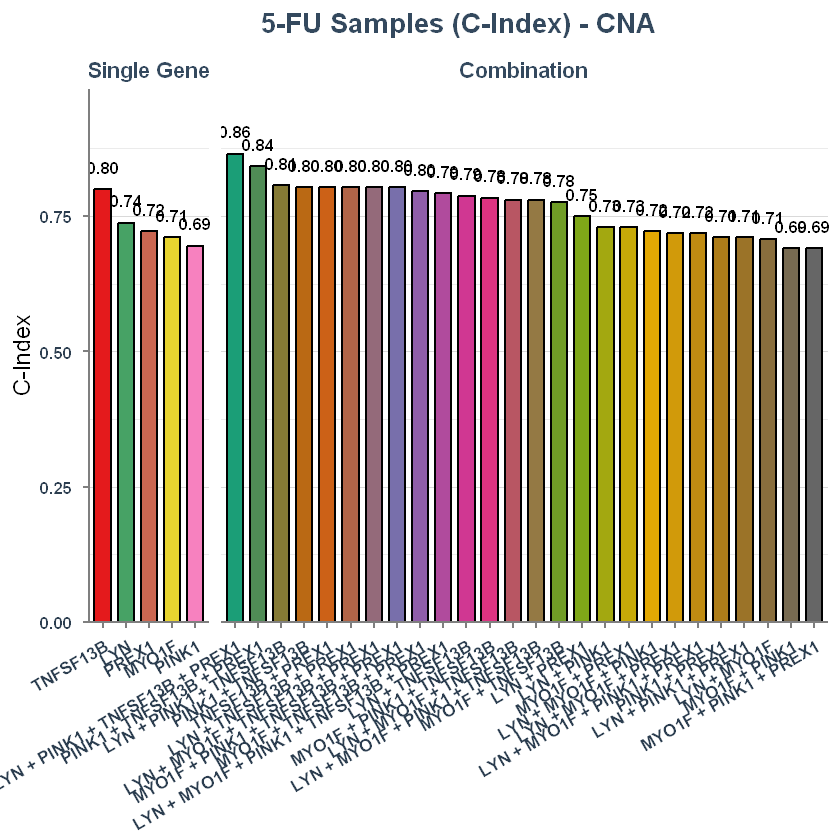

In [ ]:
#---------------------------------------------------------------------------------------------------------------
# Analyze and visualize specific gene combinations
results_LYN_MYO1F_PINK1_TNFSF13B_PREX1 = analyze_genes_for_combinations(
  gene_list = c('LYN', 'MYO1F', 'PINK1', 'TNFSF13B', 'PREX1', 'MAGED1'),
  processed_data = DNAi_Fluoroucail_ALL,
  surv_obj = DNAi_ALL_Fluoroucail_Surv,
  single_gene_model = DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel,
  seed = 73
)

# Plot the results for gene combinations
results_LYN_MYO1F_PINK1_TNFSF13B_PREX1_plot = plot_cindex_results_separate(
  results_LYN_MYO1F_PINK1_TNFSF13B_PREX1,
  '5-FU Samples (C-Index)'
)
results_LYN_MYO1F_PINK1_TNFSF13B_PREX1_plot
# Save plot for gene combinations
#saveRDS(results_LYN_MYO1F_PINK1_TNFSF13B_PREX1_plot, 'Graphs/LYN_MYO1F_PINK1_TNFSF13B_PREX1_Cindex_ALL.rds')


New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : LYN 
Not enough genes for combinations in Model_1 . Only single genes will be used.
Processing Model_2 
No valid genes for Model_2 . Skipping...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"
New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`


Processing Model_1 
Filtered gene list for Model_1 : TNFSF13B 
Not enough genes for combinations in Model_1 . Only single genes will be used.
Processing Model_2 
No valid genes for Model_2 . Skipping...


Warning message in geom_bar(stat = "identity", width = 0.7, color = "black", size = 0.2):
"Ignoring unknown parameters: `size`"


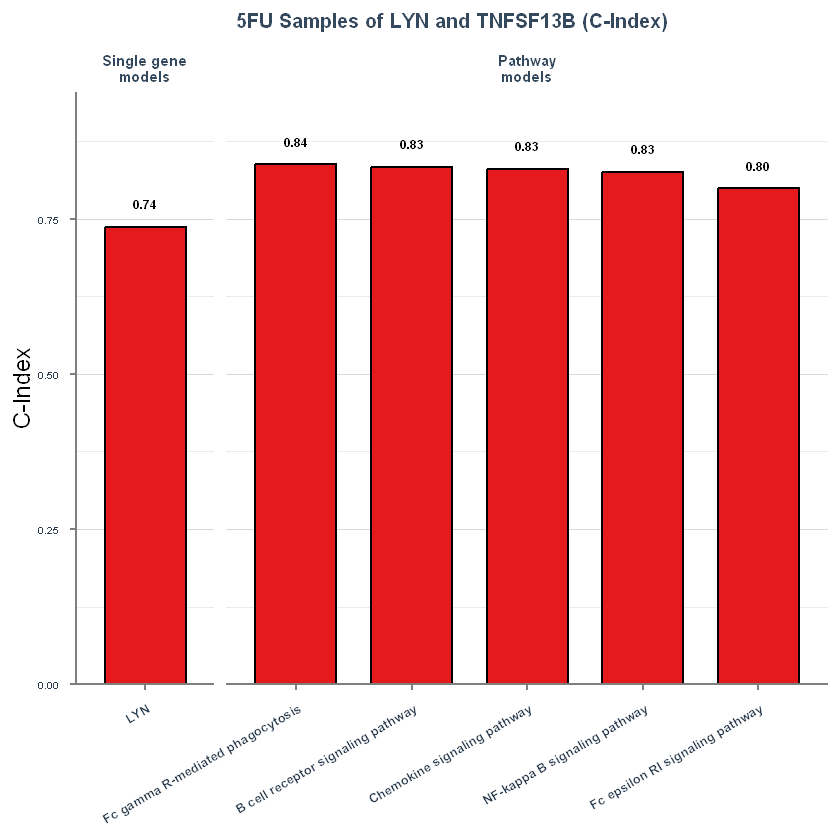

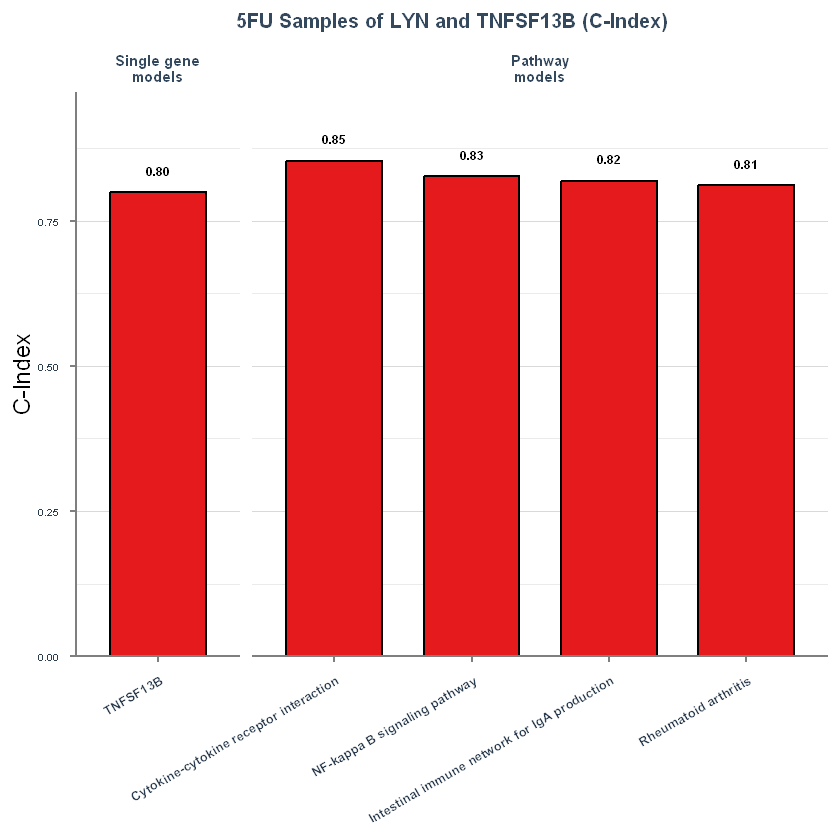

In [7]:
#---------------------------------------------------------------------------------------------------------------
# Single Gene and Pathway Analysis

# Analyze specific genes and pathways
results_LYN <- analyze_genes_and_pathways_for_models(
  gene_list = c("LYN"),
  excluded_pathways = c('Viral carcinogenesis','Long-term depression','Epithelial cell signaling in Helicobacter pylori infection','Epstein-Barr virus infection','Platelet activation','Viral myocarditis','Lipid and atherosclerosis','Kaposi sarcoma-associated herpesvirus infection',"Amyotrophic lateral sclerosis", 'Pathways of neurodegeneration - multiple diseases'),
  processed_data = DNAi_Fluoroucail_ALL,
  surv_obj = DNAi_ALL_Fluoroucail_Surv,
  single_gene_model = DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel,
  multi_cox_model = multiGeneCox_DNAi_ALL,
  enrichment_table_path = "enriched_terms.xlsx"
)

# Generate and save barplot for specific gene results
model1_results = results_LYN$Model1
plot_model1_LYN <- cindex_barplot_vertical_v5_improved(
  model1_results,
  "Model_1",
  '5FU Samples of LYN and TNFSF13B (C-Index)'
)
plot_model1_LYN
# Save plot
#saveRDS(plot_model1_LYN, 'Graphs/LYN_Cindex.rds')


#-------

# Analyze specific genes and pathways
results_TNFSF13B <- analyze_genes_and_pathways_for_models(
  gene_list = c("TNFSF13B"),
  excluded_pathways = c('Viral carcinogenesis','Long-term depression','Epithelial cell signaling in Helicobacter pylori infection','Epstein-Barr virus infection','Platelet activation','Viral myocarditis','Lipid and atherosclerosis','Kaposi sarcoma-associated herpesvirus infection',"Amyotrophic lateral sclerosis", 'Pathways of neurodegeneration - multiple diseases'),
  processed_data = DNAi_Fluoroucail_ALL,
  surv_obj = DNAi_ALL_Fluoroucail_Surv,
  single_gene_model = DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel,
  multi_cox_model = multiGeneCox_DNAi_ALL,
  enrichment_table_path = "enriched_terms.xlsx"
)

# Generate and save barplot for specific gene results
model1_results = results_TNFSF13B$Model1
plot_model1_TNFSF13B <- cindex_barplot_vertical_v5_improved(
  model1_results,
  "Model_1",
  '5FU Samples of LYN and TNFSF13B (C-Index)'
)
plot_model1_TNFSF13B
# Save plot
#saveRDS(plot_model1_TNFSF13B, 'Graphs/TNFSF13B_Cindex.rds')


In [ ]:
# Kaplan-Meier Survival Analysis

# Perform Kaplan-Meier analysis for filtered models
results <- kaplan_meier_analysis(
        model1_data = DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel$Model_1,
        model2_data = DNAi_EMC_ALL_Fluorouracil_Pen_CoxModel$Model_2,
        surv_obj = DNAi_ALL_Fluoroucail_Surv,
        processed_data = DNAi_Fluoroucail_ALL,
        hr_threshold = 1.1,
        plot = F,
        th_pval = 0.05,
        plot_title_prefix = '5-FU Samples'
)

# Save Kaplan-Meier analysis results
#saveRDS(results, 'DNAi_EMC_ALL_Fluorouracil_KM.rds')
#---------------------------------------------------------------------------------------------------------------
# Generate and save KM plots for BAMBI
CCND1_KM_ALL = results$Model1$Plots$CCND1_Interaction_cna_condition_HR
FOSL1_KM_ALL=results$Model1$Plots$FOSL1_Interaction_cna_condition_HR
CTTN_KM_ALL=results$Model1$Plots$CTTN_Interaction_cna_condition_HR
SLC43A1_KM_ALL=results$Model1$Plots$SLC43A1_Interaction_cna_condition_HR
SLC43A3_KM_ALL=results$Model1$Plots$SLC43A3_Interaction_cna_condition_HR

FRMD6_KM_ALL=results$Model2$Plots$FRMD6_Interaction_mut_condition_HR
TNC_KM_ALL=results$Model2$Plots$TNC_Interaction_mut_condition_HR


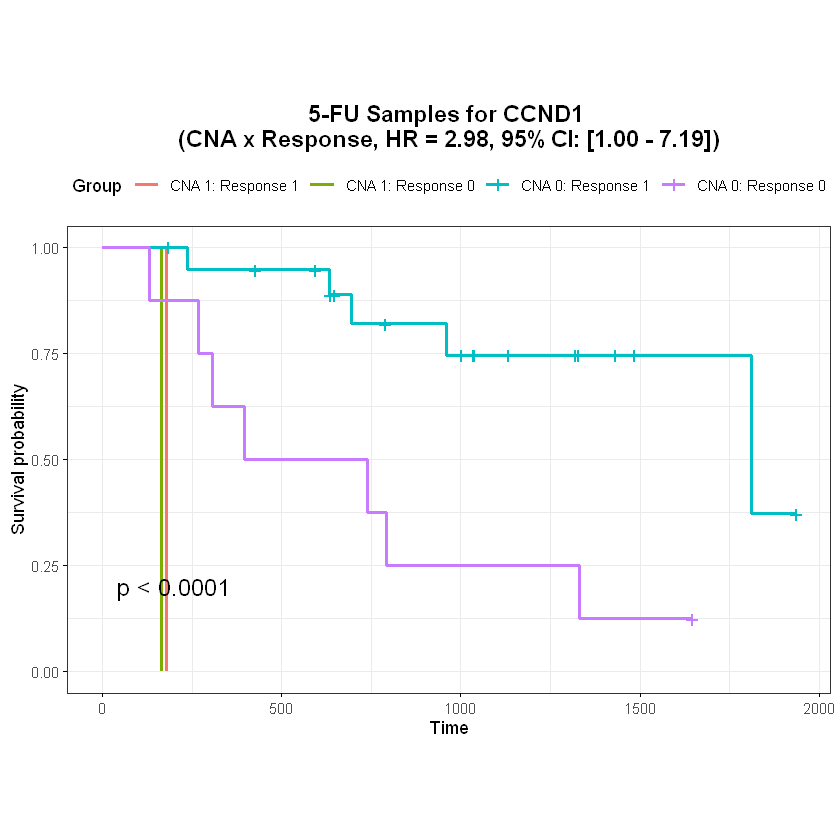

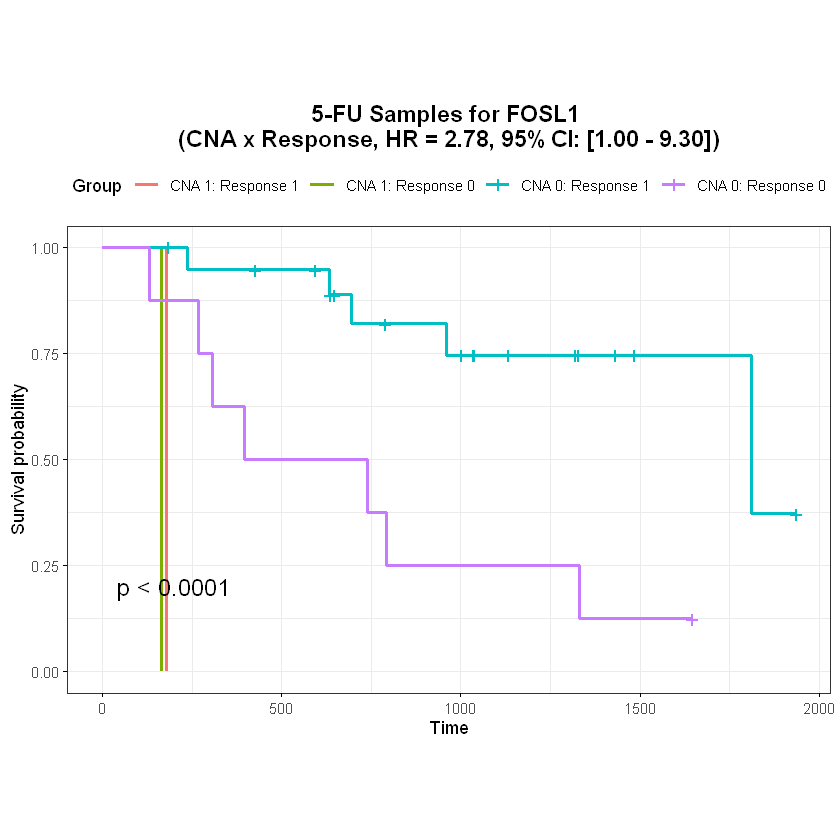

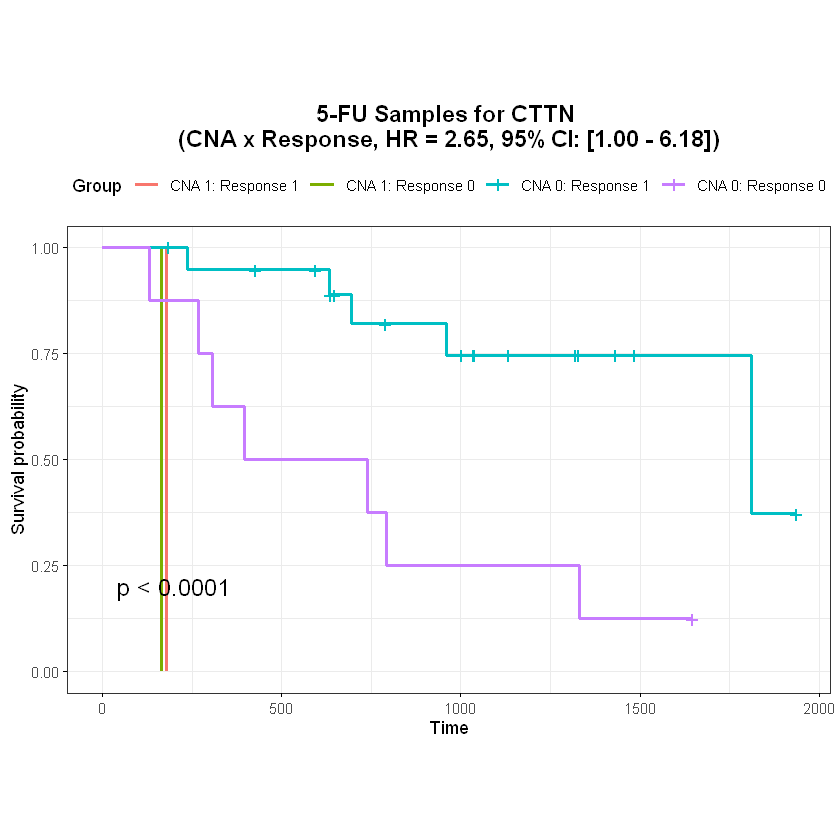

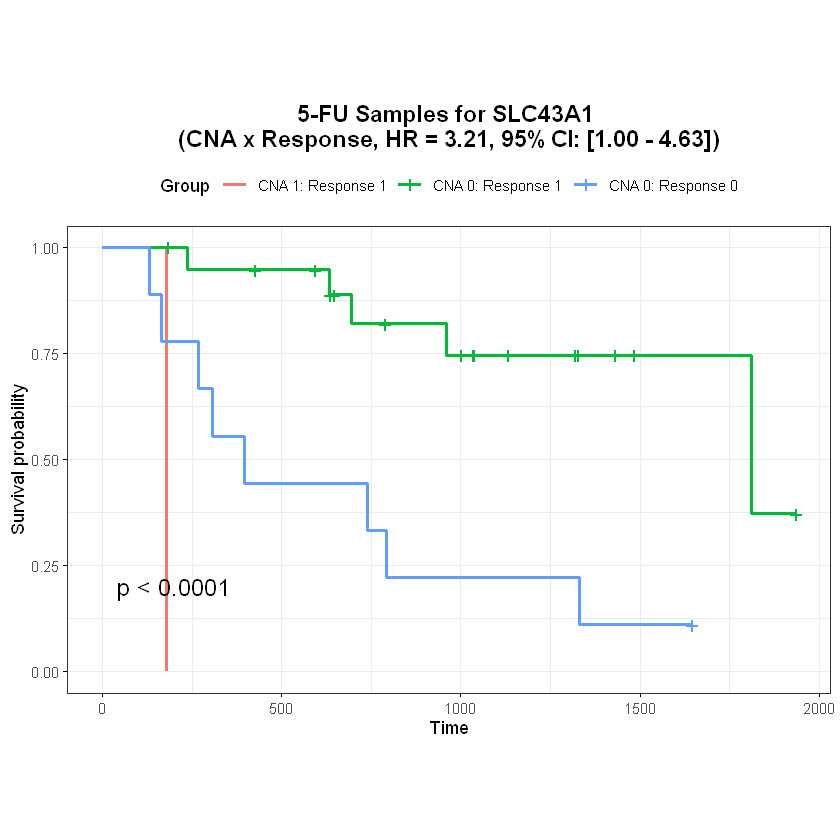

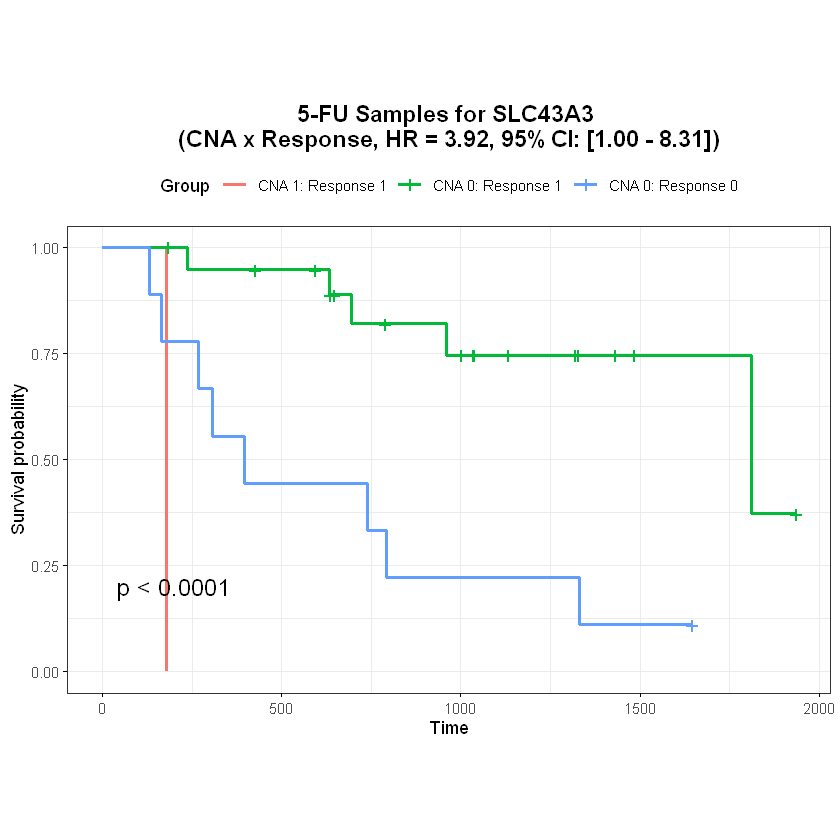

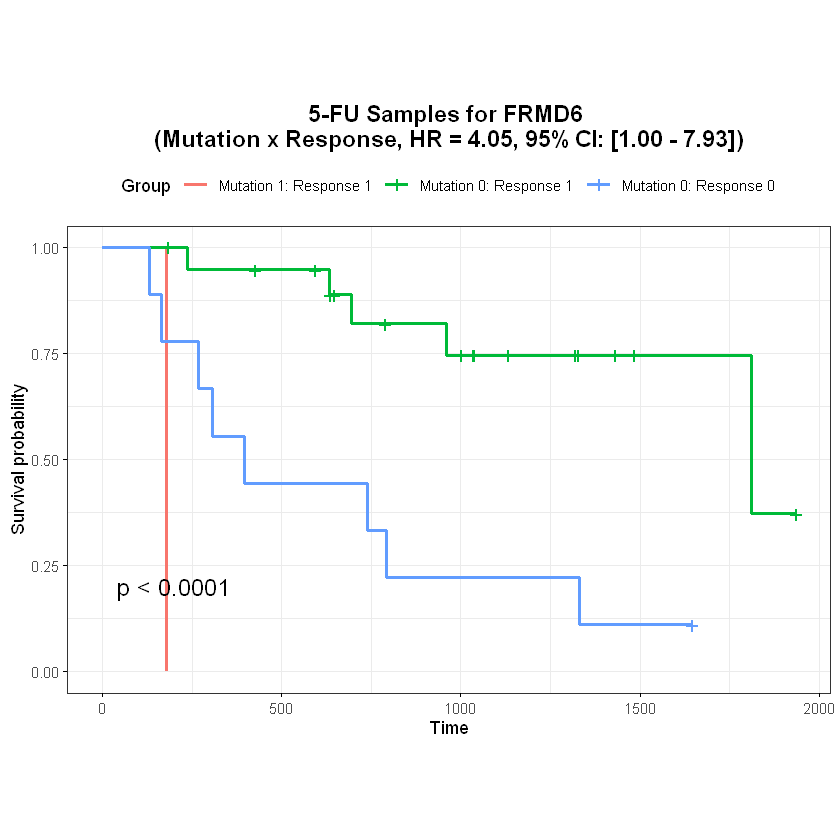

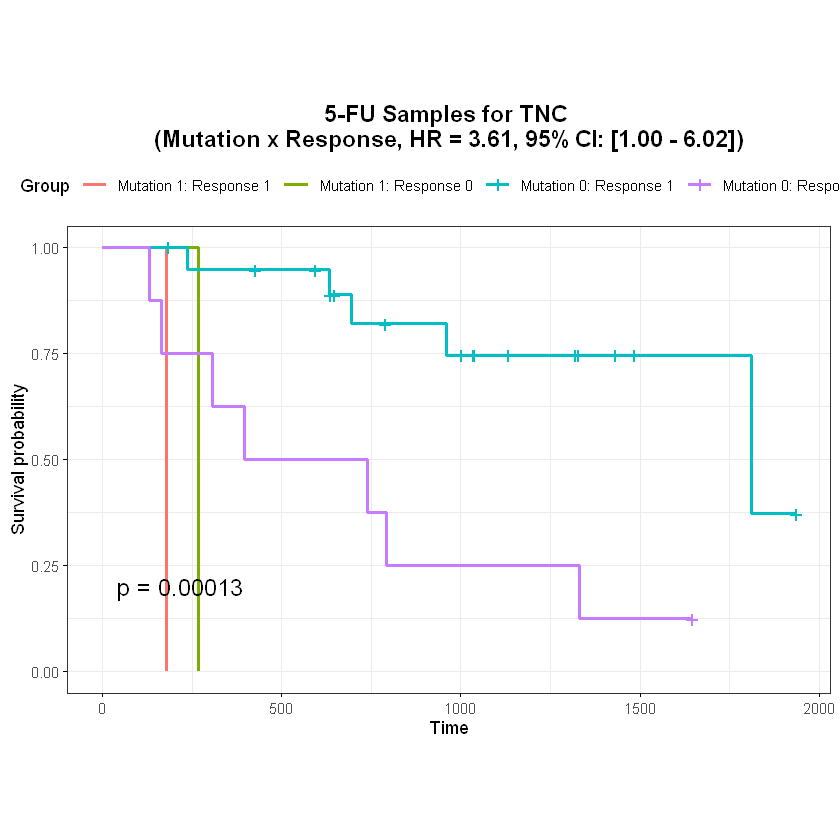

In [9]:
CCND1_KM_ALL
FOSL1_KM_ALL
CTTN_KM_ALL
SLC43A1_KM_ALL
SLC43A3_KM_ALL
FRMD6_KM_ALL
TNC_KM_ALL